**Lab2-DL: C2-cnn-trening.ipynb** (ELMED219) | Prioritet: 2 (anbefalt)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/C2-cnn-trening.ipynb)

# 🚀 C2: CNN Trening og Lagring

**Fra Natur til Medisin: Tren og Lagre CNN-modellen**

---

## 🎯 Mål for denne delen

I denne notebooken skal vi:
- **Laste inn** modell og data fra del 1
- **Trene** CNN-modellen med progress tracking
- **Visualisere** treningsresultater
- **Lagre** den trente modellen og historikk
- **Forberede** for testing i del 3

## Forutsetninger

Denne notebooken bygger på `02a_cnn_bildeklassifikasjon.ipynb`. Sørg for at du har:
- ✅ Fullført del 1
- ✅ Lagret modell og data
- ✅ Forstått CNN-arkitekturen

## 🔧 Miljøoppsett

Vi starter med å sette opp miljøet og laste inn nødvendige biblioteker.

In [1]:
import sys
import subprocess
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Kjører i Google Colab")
    
    # Installer nødvendige pakker
    !pip install seaborn --quiet
    
    # Sjekk om mappen allerede eksisterer
    if not os.path.exists('ELMED219-2026/Lab2-DL'):
        print(" Laster ned kursmateriell...")
        try:
            !git clone https://github.com/arvidl/ELMED219-2026.git
            os.chdir('ELMED219-2026/Lab2-DL')
        except:
            print("❌ Kunne ikke laste ned kursmateriell")
            print("Last ned manuelt fra: https://github.com/arvidl/ELMED219-2026")
else:
    print("💻 Kjører lokalt eller i Codespaces")
    
print("✅ Miljøoppsett fullført!")

💻 Kjører lokalt eller i Codespaces
✅ Miljøoppsett fullført!


In [2]:
# Importer nødvendige biblioteker
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# Sett random seeds for reproduserbarhet
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("📚 Biblioteker importert!")

📚 Biblioteker importert!


In [4]:
# Konfigurer enhet (CPU, GPU, eller MPS)
def setup_device():
    """Sett opp best tilgjengelig enhet"""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"🚀 Bruker GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = torch.device('mps')
        print("🍎 Bruker MPS (Apple Silicon)")
    else:
        device = torch.device('cpu')
        print("💻 Bruker CPU")
    
    return device

device = setup_device()
print(f"✅ Enhet satt til: {device}")

🍎 Bruker MPS (Apple Silicon)
✅ Enhet satt til: mps


## Last inn modell og data

Vi laster inn modellarkitekturen og dataene som ble lagret i del 1.

In [5]:
# Last inn data-info fra del 1
try:
    with open('flower_data_info.pkl', 'rb') as f:
        data_info = pickle.load(f)
    
    # Pakk ut data
    X_train = data_info['X_train']
    y_train = data_info['y_train']
    X_val = data_info['X_val']
    y_val = data_info['y_val']
    X_test = data_info['X_test']
    y_test = data_info['y_test']
    class_names = data_info['class_names']
    class_mapping = data_info['class_mapping']
    num_classes = data_info['num_classes']
    
    print("✅ Data lastet inn fra del 1!")
    print(f"📊 Treningssett: {len(X_train)} bilder")
    print(f" Valideringssett: {len(X_val)} bilder")
    print(f"📊 Testsett: {len(X_test)} bilder")
    print(f" Klasser: {class_names}")
    
except FileNotFoundError:
    print("❌ Kunne ikke finne 'flower_data_info.pkl'")
    print("💡 Sørg for at du har fullført del 1 først!")
    print("📁 Kjør '02a_cnn_bildeklassifikasjon.ipynb' først")
    raise

✅ Data lastet inn fra del 1!
📊 Treningssett: 2569 bilder
 Valideringssett: 550 bilder
📊 Testsett: 551 bilder
 Klasser: ['Tusenfryd', 'Løvetann', 'Rose', 'Solsikke', 'Tulipan']


In [6]:
# Definer transformasjoner (samme som i del 1)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Transformasjoner definert!")

✅ Transformasjoner definert!


In [7]:
# Custom Dataset klasse (samme som i del 1)
class FlowerDataset(Dataset):
    """Custom dataset for blomsterbilder"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Last bilde
        image = Image.open(image_path).convert('RGB')
        
        # Anvend transform
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Opprett datasets og DataLoaders (num_workers=0 for lokal kjøring)
train_dataset = FlowerDataset(X_train, y_train, train_transform)
val_dataset = FlowerDataset(X_val, y_val, val_transform)
test_dataset = FlowerDataset(X_test, y_test, val_transform)

# Opprett DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"✅ DataLoaders opprettet med batch_size={batch_size}")
print(f"  Treningsbatcher: {len(train_loader)}")
print(f"  Valideringsbatcher: {len(val_loader)}")
print(f"  Testbatcher: {len(test_loader)}")

✅ DataLoaders opprettet med batch_size=32
  Treningsbatcher: 81
  Valideringsbatcher: 18
  Testbatcher: 18


In [8]:
# Last inn modellarkitektur
class SimpleCNN(nn.Module):
    """Enkel CNN for blomsterklassifikasjon"""
    
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        
        # Konvolusjonslag
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout for regularisering
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected lag
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Konvolusjonsblokk 1
        x = self.pool(torch.relu(self.conv1(x)))
        
        # Konvolusjonsblokk 2
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Konvolusjonsblokk 3
        x = self.pool(torch.relu(self.conv3(x)))
        
        # Flatten for fully connected lag
        x = x.view(-1, 128 * 28 * 28)
        
        # Fully connected lag
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Opprett modell
model = SimpleCNN(num_classes=num_classes)
model = model.to(device)

print("✅ Modell opprettet og flyttet til enhet!")
print(f"🏗️ Modellarkitektur: {model.__class__.__name__}")
print(f"📊 Antall parametere: {sum(p.numel() for p in model.parameters()):,}")

✅ Modell opprettet og flyttet til enhet!
🏗️ Modellarkitektur: SimpleCNN
📊 Antall parametere: 51,476,549


## 🚀 Treningsfunksjoner

Nå definerer vi funksjonene for trening og validering av modellen.

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Tren modellen i en epoke"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Valider modellen i en epoke"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

print("✅ Treningsfunksjoner definert!")

✅ Treningsfunksjoner definert!


In [10]:
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    """Tren modellen med progress tracking"""
    
    # Loss function og optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    # Lagre treningshistorikk
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    patience_counter = 0
    
    print(" Starter trening...")
    print("=" * 60)
    print(f"📊 Antall epoker: {num_epochs}")
    print(f"📊 Learning rate: {learning_rate}")
    print(f"📊 Batch size: {train_loader.batch_size}")
    print(f"📊 Enhet: {device}")
    print("=" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        print(f"\nEpoke {epoch+1}/{num_epochs}")
        print("-" * 30)
        
        # Tren
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Valider
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Oppdater learning rate
        scheduler.step(val_loss)
        
        # Lagre metrikker
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Beregn tid
        epoch_time = time.time() - epoch_start
        
        # Vis progress
        print(f"Trenings-Loss: {train_loss:.4f}, Trenings-Accuracy: {train_acc:.2f}%")
        print(f"Validerings-Loss: {val_loss:.4f}, Validerings-Accuracy: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print(f"Epoke-tid: {epoch_time:.1f}s")
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Lagre beste modell
            torch.save(model.state_dict(), 'best_flower_model.pth')
            print(f"💾 Ny beste modell lagret! (Accuracy: {val_acc:.2f}%)")
        else:
            patience_counter += 1
            print(f"⏳ Ingen forbedring i {patience_counter} epoker")
        
        if patience_counter >= 5:
            print(f"\n⏹️ Early stopping ved epoke {epoch+1}")
            break
    
    total_time = time.time() - start_time
    
    print("\n✅ Trening fullført!")
    print(f"⏱️ Total tid: {total_time/60:.1f} minutter")
    print(f" Beste validerings-accuracy: {best_val_acc:.2f}%")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses, 
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'total_time': total_time
    }

print("✅ Treningsfunksjon definert!")

✅ Treningsfunksjon definert!


## 🚀 Start trening

Nå starter vi treningen av modellen. Dette kan ta noen minutter avhengig av regnekapasiteten du benytter (ca. 4 1/2 min på MacBook Pro M4 Max)

In [11]:
%%time
# Kjør trening
print("🚀 Starter trening av modellen...")
print("⏳ Dette kan ta noen minutter avhengig av enheten din...")

history = train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=0.001)

print("\n📊 Treningsresultater:")
print(f"  Siste trenings-accuracy: {history['train_accs'][-1]:.2f}%")
print(f"  Siste validerings-accuracy: {history['val_accs'][-1]:.2f}%")
print(f"  Beste validerings-accuracy: {history['best_val_acc']:.2f}%")
print(f"  Total treningstid: {history['total_time']/60:.1f} minutter")

🚀 Starter trening av modellen...
⏳ Dette kan ta noen minutter avhengig av enheten din...
 Starter trening...
📊 Antall epoker: 25
📊 Learning rate: 0.001
📊 Batch size: 32
📊 Enhet: mps

Epoke 1/25
------------------------------
Trenings-Loss: 1.7165, Trenings-Accuracy: 33.09%
Validerings-Loss: 1.3065, Validerings-Accuracy: 41.45%
Learning Rate: 0.001000
Epoke-tid: 27.3s
💾 Ny beste modell lagret! (Accuracy: 41.45%)

Epoke 2/25
------------------------------
Trenings-Loss: 1.3535, Trenings-Accuracy: 43.40%
Validerings-Loss: 1.2111, Validerings-Accuracy: 48.91%
Learning Rate: 0.001000
Epoke-tid: 9.7s
💾 Ny beste modell lagret! (Accuracy: 48.91%)

Epoke 3/25
------------------------------
Trenings-Loss: 1.2407, Trenings-Accuracy: 47.18%
Validerings-Loss: 1.0861, Validerings-Accuracy: 56.18%
Learning Rate: 0.001000
Epoke-tid: 9.8s
💾 Ny beste modell lagret! (Accuracy: 56.18%)

Epoke 4/25
------------------------------
Trenings-Loss: 1.2047, Trenings-Accuracy: 51.23%
Validerings-Loss: 1.0323, Val

## 📈 Visualisering av treningsresultater

La oss visualisere hvordan modellen lærte under treningen.

 Visualiserer treningsresultater...


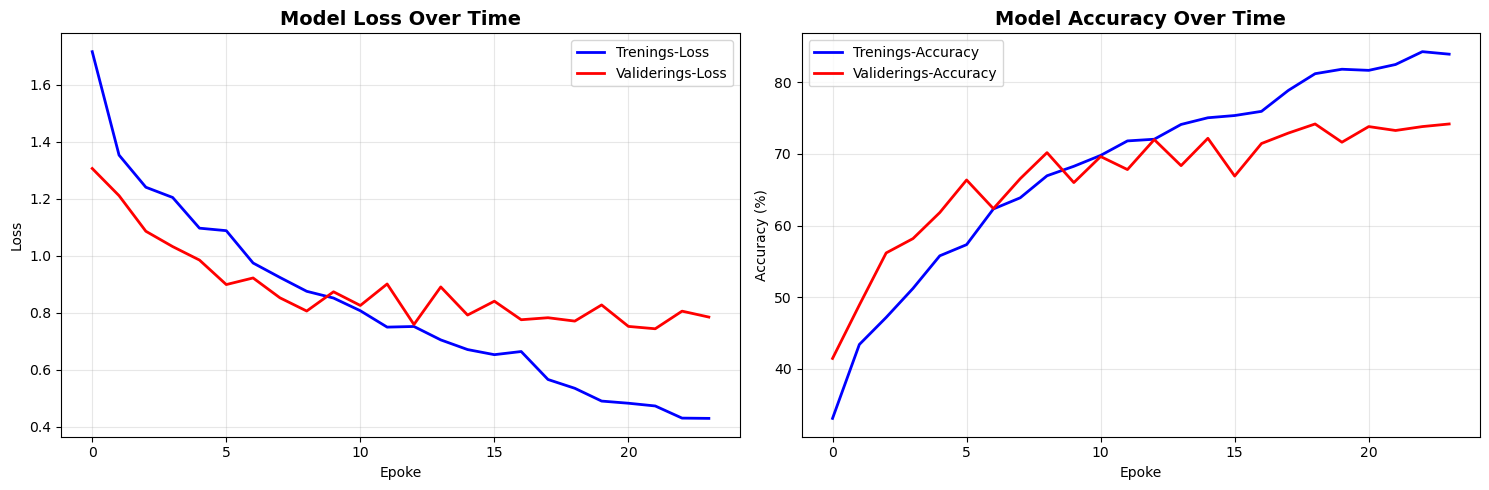

In [12]:
def plot_training_history(history):
    """Plot treningshistorikk"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history['train_losses'], label='Trenings-Loss', color='blue', linewidth=2)
    axes[0].plot(history['val_losses'], label='Validerings-Loss', color='red', linewidth=2)
    axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoke')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(history['train_accs'], label='Trenings-Accuracy', color='blue', linewidth=2)
    axes[1].plot(history['val_accs'], label='Validerings-Accuracy', color='red', linewidth=2)
    axes[1].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoke')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot treningshistorikk
print(" Visualiserer treningsresultater...")
plot_training_history(history)

 Viser sammendrag av treningsresultater...


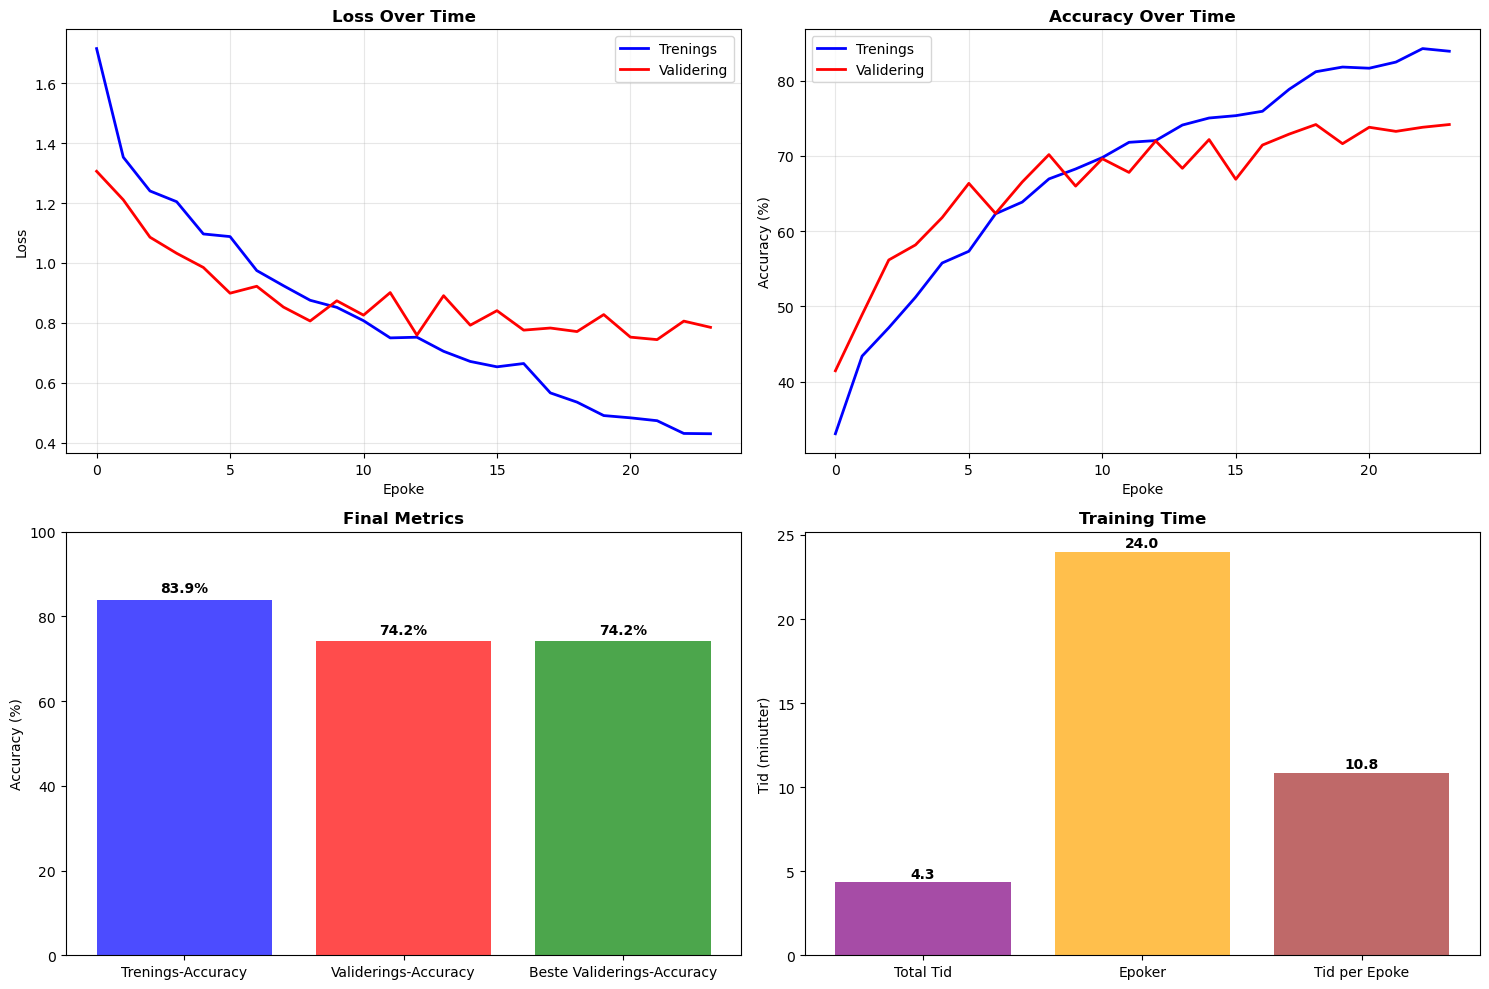

In [13]:
def plot_training_summary(history):
    """Plot sammendrag av treningsresultater"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Loss over time
    axes[0, 0].plot(history['train_losses'], label='Trenings', color='blue', linewidth=2)
    axes[0, 0].plot(history['val_losses'], label='Validering', color='red', linewidth=2)
    axes[0, 0].set_title('Loss Over Time', fontweight='bold')
    axes[0, 0].set_xlabel('Epoke')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Accuracy over time
    axes[0, 1].plot(history['train_accs'], label='Trenings', color='blue', linewidth=2)
    axes[0, 1].plot(history['val_accs'], label='Validering', color='red', linewidth=2)
    axes[0, 1].set_title('Accuracy Over Time', fontweight='bold')
    axes[0, 1].set_xlabel('Epoke')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Final metrics
    final_metrics = {
        'Trenings-Accuracy': history['train_accs'][-1],
        'Validerings-Accuracy': history['val_accs'][-1],
        'Beste Validerings-Accuracy': history['best_val_acc']
    }
    
    bars = axes[1, 0].bar(final_metrics.keys(), final_metrics.values(), 
                         color=['blue', 'red', 'green'], alpha=0.7)
    axes[1, 0].set_title('Final Metrics', fontweight='bold')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_ylim(0, 100)
    
    # Legg til verdier på balkene
    for bar, value in zip(bars, final_metrics.values()):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 4. Training time
    time_info = {
        'Total Tid': history['total_time']/60,
        'Epoker': len(history['train_accs']),
        'Tid per Epoke': history['total_time']/len(history['train_accs'])
    }
    
    bars = axes[1, 1].bar(time_info.keys(), time_info.values(), 
                         color=['purple', 'orange', 'brown'], alpha=0.7)
    axes[1, 1].set_title('Training Time', fontweight='bold')
    axes[1, 1].set_ylabel('Tid (minutter)')
    
    # Legg til verdier på balkene
    for bar, value in zip(bars, time_info.values()):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Plot sammendrag
print(" Viser sammendrag av treningsresultater...")
plot_training_summary(history)

## 🔍 Analyse av treningsresultater

La oss analysere treningsresultatene for å forstå hvordan modellen lærte.

In [14]:
def analyze_training_results(history):
    """Analyser treningsresultater"""
    
    print(" Analyse av treningsresultater:")
    print("=" * 50)
    
    # Grunnleggende statistikk
    final_train_acc = history['train_accs'][-1]
    final_val_acc = history['val_accs'][-1]
    best_val_acc = history['best_val_acc']
    
    print(f" Final trenings-accuracy: {final_train_acc:.2f}%")
    print(f"📊 Final validerings-accuracy: {final_val_acc:.2f}%")
    print(f" Beste validerings-accuracy: {best_val_acc:.2f}%")
    
    # Overfitting-analyse
    overfitting_gap = final_train_acc - final_val_acc
    print(f"\n🔍 Overfitting-analyse:")
    print(f"  Gap mellom trenings- og validerings-accuracy: {overfitting_gap:.2f}%")
    
    if overfitting_gap > 10:
        print("  ⚠️ Modellen viser tegn til overfitting (gap > 10%)")
    elif overfitting_gap > 5:
        print("  ⚠️ Modellen viser moderate tegn til overfitting (gap > 5%)")
    else:
        print("  ✅ Modellen generaliserer godt (liten gap)")
    
    # Konvergens-analyse
    print(f"\n Konvergens-analyse:")
    print(f"  Antall epoker: {len(history['train_accs'])}")
    print(f"  Total treningstid: {history['total_time']/60:.1f} minutter")
    print(f"  Gjennomsnittlig tid per epoke: {history['total_time']/len(history['train_accs']):.1f} sekunder")
    
    # Ytelse-vurdering
    print(f"\n🔍 Ytelse-vurdering:")
    if best_val_acc >= 90:
        print("  Utmerket ytelse! (≥90%)")
    elif best_val_acc >= 80:
        print("  God ytelse! (≥80%)")
    elif best_val_acc >= 70:
        print("  👍 Akseptabel ytelse (≥70%)")
    else:
        print("  ⚠️ Modellen trenger forbedring (<70%)")
    
    # Anbefalinger
    print(f"\n💡 Anbefalinger:")
    if overfitting_gap > 10:
        print("  - Øk dropout-raten")
        print("  - Legg til mer dataaugmentering")
        print("  - Reduser modellkompleksiteten")
    
    if best_val_acc < 80:
        print("  - Tren i flere epoker")
        print("  - Prøv forskjellige learning rates")
        print("  - Vurder å endre modellarkitekturen")
    
    if best_val_acc >= 80:
        print("  - Modellen er klar for evaluering!")
        print("  - Gå videre til del 3 for testing")

# Analyser resultater
analyze_training_results(history)

 Analyse av treningsresultater:
 Final trenings-accuracy: 83.92%
📊 Final validerings-accuracy: 74.18%
 Beste validerings-accuracy: 74.18%

🔍 Overfitting-analyse:
  Gap mellom trenings- og validerings-accuracy: 9.74%
  ⚠️ Modellen viser moderate tegn til overfitting (gap > 5%)

 Konvergens-analyse:
  Antall epoker: 24
  Total treningstid: 4.3 minutter
  Gjennomsnittlig tid per epoke: 10.8 sekunder

🔍 Ytelse-vurdering:
  👍 Akseptabel ytelse (≥70%)

💡 Anbefalinger:
  - Tren i flere epoker
  - Prøv forskjellige learning rates
  - Vurder å endre modellarkitekturen


## 💾 Lagring av trent modell

Vi lagrer den trente modellen og treningshistorikken for bruk i del 3.

In [15]:
# Last inn beste modell
model.load_state_dict(torch.load('best_flower_model.pth'))
print("✅ Beste modell lastet inn!")

# Lagre komplett modell
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': 'SimpleCNN',
    'num_classes': num_classes,
    'class_names': class_names,
    'class_mapping': class_mapping,
    'training_history': history
}, 'trained_flower_model.pth')

# Lagre treningshistorikk separat
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("✅ Modell og historikk lagret!")
print(" Filer opprettet:")
print("  - best_flower_model.pth (beste modell)")
print("  - trained_flower_model.pth (komplett modell)")
print("  - training_history.pkl (treningshistorikk)")

✅ Beste modell lastet inn!
✅ Modell og historikk lagret!
 Filer opprettet:
  - best_flower_model.pth (beste modell)
  - trained_flower_model.pth (komplett modell)
  - training_history.pkl (treningshistorikk)


## Oppsummering og neste steg

### Hva vi har oppnådd:
- ✅ Lastet inn modell og data fra del 1
- ✅ Trente CNN-modellen med progress tracking
- ✅ Visualisert treningsresultater
- ✅ Analysert modellens ytelse
- ✅ Lagret trent modell og historikk

### Neste steg (del 3):
- 🧪 Testing av modellen på testsettet
- 🔍 Forvirringsmatrise og metrikker
- 🔍 Forklarbar AI (CAM, Grad-CAM)
- 🔍 Detaljert evaluering

### Refleksjonsspørsmål:
1. **Hvorfor** bruker vi early stopping i treningen?
2. **Hva** forteller treningskurvene oss om modellens læring?
3. **Hvordan** kan vi identifisere overfitting?
4. **Hvorfor** er det viktig å lagre både modell og historikk?

---

**Gå videre til del 3: `02c_cnn_testing.ipynb`**